In [1]:
import os

import tempfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

/home/dmitri/projects/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/dmitri/projects/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/dmitri/projects/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


acquire loaded weights:

In [2]:
caffe_root = '/home/dmitri/projects/caffe/'
pretrained_weights_path = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
assert os.path.exists(pretrained_weights_path)

define default structure of caffenet:

In [3]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(data,
             label=None,
             train=True,
             num_classes=1000,
             classifier_name='fc8',
             learn_all=False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6
        
    n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=param)
    if train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    # write the net to a temporary file and return its filename
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(n.to_proto()))
        print('created net there ->', f.name)
        return f.name

In [4]:
def create_style_recognize_net(train=True, learn_all=False, subset=None):
    if subset is None:
        subset = 'train' if train else 'test'
    source = '/home/dmitri/projects/graphicon_paper/dataset/video10_train2/{}.txt'.format(subset)
    assert os.path.isfile(source), source
    mean_file_ = caffe_root + 'data/ilsvrc12/scene_ass_mean.binaryproto' #scene_ass imagenet
    assert os.path.isfile(mean_file_), mean_file_
    transform_param = dict(mirror=train,
                           crop_size=227,
                           mean_file=mean_file_)
    
    style_data, style_label = L.ImageData(transform_param = transform_param,
                                          source = source,
                                          batch_size = 50,
                                          new_height = 256,
                                          new_width = 256,
                                          ntop = 2)
    
    return caffenet(data = style_data,
                    label = style_label,
                    train = train,
                    num_classes = 2,
                    classifier_name = 'fc8_sceneassoc',
                    learn_all = learn_all)


In [5]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path=None, base_lr=0.001):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 100000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 20000

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = os.path.dirname(os.path.abspath('.'))
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

In [6]:
def run_solvers(niter, solvers, disp_interval=10):
    """Run solvers for niter iterations,
       returning the loss and accuracy recorded each iteration.
       `solvers` is a list of (name, solver) tuples."""
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)     
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, acc, weights

('created net there ->', '/tmp/tmpzYu7GG')
/tmp/tmpdmkGoZ
Running solver for 10000 iterations...
  0) pretrained: loss=0.693, acc=30%
 10) pretrained: loss=0.319, acc=80%
 20) pretrained: loss=0.482, acc=78%
 30) pretrained: loss=0.277, acc=90%
 40) pretrained: loss=0.095, acc=100%
 50) pretrained: loss=0.132, acc=96%
 60) pretrained: loss=0.252, acc=92%
 70) pretrained: loss=0.287, acc=92%
 80) pretrained: loss=0.317, acc=90%
 90) pretrained: loss=0.121, acc=98%
100) pretrained: loss=0.228, acc=94%
110) pretrained: loss=0.110, acc=94%
120) pretrained: loss=0.106, acc=98%
130) pretrained: loss=0.102, acc=96%
140) pretrained: loss=0.284, acc=92%
150) pretrained: loss=0.084, acc=96%
160) pretrained: loss=0.148, acc=94%
170) pretrained: loss=0.054, acc=98%
180) pretrained: loss=0.128, acc=94%
190) pretrained: loss=0.044, acc=100%
200) pretrained: loss=0.060, acc=100%
210) pretrained: loss=0.129, acc=94%
220) pretrained: loss=0.116, acc=94%
230) pretrained: loss=0.103, acc=96%
240) pretrai

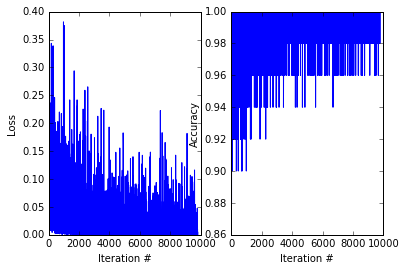

In [7]:
niter = 10000

# Reset style_solver as before.
style_solver_filename = solver(create_style_recognize_net(train = True, learn_all = True))
print(style_solver_filename)
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(pretrained_weights_path)

print 'Running solver for %d iterations...' % niter
solvers = [('pretrained', style_solver)]
loss, acc, weights = run_solvers(niter, solvers)
print 'Done.'

train_loss = loss['pretrained']
train_acc = acc['pretrained']
style_weights = weights['pretrained']
print 'trained weights', style_weights
print(train_loss.shape)

f, ax = plt.subplots(1, 2)
ax[0].plot(train_loss[200:].T)
ax[0].set_xlabel('Iteration #')
ax[0].set_ylabel('Loss')
ax[1].plot(train_acc[200:].T)
ax[1].set_xlabel('Iteration #')
ax[1].set_ylabel('Accuracy')
plt.show()

In [10]:
import csv
import scipy as sp
import scipy.ndimage

def infer_styles(model, infer_weigths, outfile):
    #mean_image_npy = caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy'
    mean_image_npy = caffe_root + 'data/ilsvrc12/scene_ass_mean.npy'
    assert os.path.isfile(mean_image_npy), mean_image_npy
    test_net = caffe.Classifier(model,
                                infer_weigths,
                                mean = \
                                    np.load(mean_image_npy).mean(1).mean(1),
                                channel_swap=(2,1,0),
                                raw_scale=255,
                                image_dims=(227, 227))

    with open(outfile, 'w') as the_file:        
        writer = csv.writer(the_file, delimiter = ',')
        field_names = ['Id', 'Category']
        writer.writerow(field_names)
        set_fullpath = '/home/dmitri/projects/graphicon_paper/dataset/video10sh_train_'
        count_diff = 0
        count_same = 0
        for image_path in os.listdir(set_fullpath):
            if not image_path.endswith('png'):
                continue
            full_image_path = os.path.join(set_fullpath, image_path)
            
            #caffe.io.load_image
            predictions = test_net.predict([sp.ndimage.imread(full_image_path)])[0]
            #print(predictions)
            prediction = np.argmax(predictions)
            if 0 == prediction:
                #print('did image {}'.format(full_image_path))   
                #print(predictions)
                count_diff += 1
            else:
                count_same += 1
            writer.writerow([image_path.split('.')[0], str(prediction)])
        print('if first 1525 got {} diff and {} same'.format(count_diff, count_same))
            

#model = './basic_canvasstylenet'
model = 'alex_deploy'#tmpYivBDh_deploy'#tmpJFKGLk_deploy'


current_weigths = 'weights.pretrained.caffemodel2'

outfile = 'scenes_infered.csv'
infer_styles(model, current_weigths, outfile)

if first 1525 got 3 diff and 1522 same


In [11]:
import csv

def get_image_distance(f1, f2):
    ffs = []
    for f in [f1, f2]:
        ffs.append(f.astype(float) / 255)

    diff = ffs[0] - ffs[1]
    for ch, chn in enumerate(['r', 'g', 'b']):
        diff_ch_range = np.max(diff[:, :, ch]) - np.min(diff[:, :, ch])
        diff[:, :, ch] = diff[:, :, ch] / diff_ch_range
        diff[:, :, ch] = diff[:, :, ch] - np.min(diff[:, :, ch])
        diff *= 255.  
        return diff.astype(np.uint8)

def infer_styles(model, infer_weigths, outfile):
    #mean_image_npy = caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy'
    mean_image_npy = caffe_root + 'data/ilsvrc12/scene_ass_mean.npy'
    assert os.path.isfile(mean_image_npy), mean_image_npy
    test_net = caffe.Classifier(model,
                                infer_weigths,
                                mean = \
                                    np.load(mean_image_npy).mean(1).mean(1),
                                channel_swap=(2,1,0),
                                raw_scale=255,
                                image_dims=(227, 227))

    with open(outfile, 'w') as the_file:        
        writer = csv.writer(the_file, delimiter = ',')
        field_names = ['Id', 'Category']
        writer.writerow(field_names)
        set_fullpath = '/home/dmitri/projects/graphicon_paper/dataset/video10sh'
        count_diff = 0
        count_same = 0
        all_ = 1525
        for image_path_i in os.listdir(set_fullpath):
            if not image_path_i.endswith('png'):
                continue
            full_image_path_i = os.path.join(set_fullpath, image_path_i)
            for image_path_j in os.listdir(set_fullpath):
                if not image_path_j.endswith('png'):
                    continue
                full_image_path_j = os.path.join(set_fullpath, image_path_j)
                if full_image_path_j == full_image_path_i:
                    continue

                if count_diff + count_same >= all_:
                    break
                f1 = caffe.io.load_image(full_image_path_i)
                f2 = caffe.io.load_image(full_image_path_j)
                diff = get_image_distance(f1, f2)
                predictions = test_net.predict([diff])[0]
                #print(predictions)
                prediction = np.argmax(predictions)
                if 0 == prediction:
                    #print('did image {}'.format(full_image_path))   
                    #print(predictions)
                    count_diff += 1
                else:
                    count_same += 1
                writer.writerow([full_image_path_i.split('.')[0] + full_image_path_j.split('.')[0],  str(prediction)])
                
        print('if first 1525 got {} diff and {} same'.format(count_diff, count_same))
            

#model = './basic_canvasstylenet'
model = 'alex_deploy'#tmpYivBDh_deploy'#tmpJFKGLk_deploy'


current_weigths = 'weights.pretrained.caffemodel2'

outfile = 'scenes_infered.csv'
infer_styles(model, current_weigths, outfile)

if first 1525 got 12 diff and 1513 same
